Plan:
v0.1:
Decision makers: creator
Focal decision: send a follow to a user
Arms: user types

Preparation:
1. Create primary reward: 1st degree follows within a week of receiving the follow
2. Create secondary reward: 2nd degree follows within a week of the primary reward

Recipe:
1. Loop over follows sent by successful creators
2. Use TS to sample the next 

In [1]:
#Run parameters
#used to control every run. Can be user to perfom sensitivity checks
path_dir = r"/Users/../Volumes/Raw/"

low_success = 0.5 #below the median: unsuccessful
high_success = 0.9 #top 10% creators with more followers are deemed successful

low_user_outdegree = 0.25 
high_user_outdegree = 0.75
low_user_activity = 0.25 
high_user_activity = 0.75 

activity_filter = 0
days_delta = 7

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from collections import Counter
from src.utils import import_dta, import_tracks_dta,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import os
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta

In [3]:
def process_date(date):
    '''convert date format like '2013-w09' to '2013-03-04', i.e. the first day of that week'''
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

# Data Imports

In [4]:
table_data = pd.read_csv('user_types_ids.csv')

hermit_ids = table_data.loc[table_data.Type =='Hermit'].user_id.unique()
w_a_ids = table_data.loc[table_data.Type =='w_a'].user_id.unique()
f_a_ids = table_data.loc[table_data.Type =='f_a'].user_id.unique()
observer_ids = table_data.loc[table_data.Type =='Observer'].user_id.unique()

In [5]:
comments_received_35k = import_dta(path_dir, "12sample_comments_received.dta");
shares_received_35k = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received_35k = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received_35k = import_dta(path_dir, "12sample_messages_received.dta");

if 'song_id' in shares_received_35k:
        shares_received_35k.drop(columns=["song_id"])
shares_received_35k = shares_received_35k[['reposter_id', "owner_id", 'created_at']]
shares_received_35k['outbound_activity'] = 'share'
shares_received_35k.columns = ['fan_id', 'user_id', 'date_sent', 'outbound_activity']

if 'track_id' in likes_received_35k:
        likes_received_35k = likes_received_35k.drop(columns=["track_id"])
likes_received_35k['outbound_activity'] = 'like'
likes_received_35k.columns = ['fan_id', 'user_id', 'date_sent', 'outbound_activity']

if 'track_id' in comments_received_35k:
        comments_received_35k = comments_received_35k.drop(columns=["track_id"])
comments_received_35k['outbound_activity'] = 'comment'
comments_received_35k.columns = ['fan_id', 'user_id', 'date_sent', 'outbound_activity']

messages_received_35k["outbound_activity"] = 'message'
messages_received_35k.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

user_activity_data_35k = pd.concat([shares_received_35k, likes_received_35k, comments_received_35k, messages_received_35k])

user_activity_data_35k['day_yr_date'] = user_activity_data_35k.date_sent.dt.normalize()

shares = user_activity_data_35k.loc[user_activity_data_35k.outbound_activity == 'share']

%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)


In [6]:
#affiliations :follows
#favoritings :likes

#used in filtering:
path_dir = r"/Users/../Volumes/Raw/"
tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");

#these are the actions sent to 
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

#Used to track information on the 1st degree connections
user_info_1st = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_1st.columns = ['user_id', 'type', 'entered_platform'];
user_info = import_dta(path_dir, "12sample_user_infos.dta");

#Used to compute creator's success measure
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)


In [7]:
mask = (tracks.track_available == 1) & (tracks.public == 't')
creator_ids = tracks[mask].user_id.unique()

creators = tracks[(tracks.track_available == 1) & (tracks.public == 't')]

In [8]:
def gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent, messages_sent, creator_ids = creator_ids):
    '''
    Creates dataframe containing the actions that content creators send to users.
        Attributes:
                    follows_sent:  dataframe with the follows sent by the 35k users.
                    shares_sent:   dataframe with the shares sent by the 35k users.
                    likes_sent:    dataframe with the likes sent by the 35k users.
                    comments_sent: dataframe with the comments sent by the 35k users.
                    messages_sent: dataframe with the messages sent by the 35k users.
                    creator_ids:   list with content creator ids. If not none, is used to
                                   filter out activities from non creators.
    '''
    
    follows_sent['outbound_activity'] = 'follow'
    follows_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'song_id' in shares_sent.columns:
        shares_sent.drop(columns=["song_id"])
    shares_sent = shares_sent[['reposter_id', "owner_id", 'created_at']]
    shares_sent['outbound_activity'] = 'share'
    shares_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in likes_sent.columns:
        likes_sent.drop(columns=["track_id"], inplace=True)
    likes_sent['outbound_activity'] = 'like'
    likes_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in comments_sent.columns:
        comments_sent.drop(columns=["track_id"], inplace=True)
    comments_sent['outbound_activity'] = 'comment'
    comments_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    messages_sent["outbound_activity"] = 'message'
    messages_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']
    df = pd.concat([follows_sent, shares_sent, likes_sent, comments_sent, messages_sent])


    if type(creator_ids) == numpy.ndarray:
        df = df[df['user_id'].isin(creator_ids)]
        
    df['week_yr'] = df.date_sent.dt.strftime('%Y-w%U')
    df = df.loc[df['user_id'] != df['fan_id'],:]

    return df

In [9]:
actions_sent = gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent,
                                     messages_sent, creator_ids = None)
actions_sent = actions_sent.loc[actions_sent.user_id.isin(creators.user_id.unique())]

active_users_ids = actions_sent.groupby('user_id', as_index = False).size()
mask = active_users_ids['size']>= activity_filter
active_users_ids = active_users_ids[mask].user_id.unique()

In [10]:
def successful_creators_followers(follows_received, base_date = datetime(2016, 5, 30, 0, 0), perc1 = None, perc2 = None, subset_creators = None):
    '''Classifies content creators in successful or unsuccessfull
        Arguments:
                    follows_received: dataframe containing the follows received by content creators
                    base date:        date, in datetime.datetime(YYYY, M, DD, H, M) format, in which the number 
                                      of followers per creator is calculated.
                    perc1:            the threshold used to classify unsuccessful content creators. Creator having 
                                      total followers below the number dictated by this threshold, at the base date,
                                      are classified as unsuccessful 
                    perc2:            the threshold used to classify successful content creators. Creator having 
                                      total followers above the number dictated by this threshold, at the base date,
                                      are classified as successful
                    subset_creators:  a pd.DataFrame containing the creators. If is it available, it will be used to 
                                      filter out non creators and to make sure creators with 0 followers are part of
                                      the resulting dataset.
        
    '''
    print(base_date)

    if 'inbound_activity' not in follows_received.columns:
        follows_received.columns = ['fan_id', 'user_id', 'date_sent']

    mask = (follows_received['date_sent'] < base_date)

    df = follows_received[mask].groupby('user_id', as_index=False).agg({'fan_id': pd.Series.nunique})
    df.columns = ['user_id', 'followers']

    
    if type(subset_creators) == pd.DataFrame:
        print('subsetting...')
        df.set_index('user_id', inplace = True)
        df = df.reindex(subset_creators.user_id.unique())
        df.fillna(0, inplace = True)
        df.reset_index(inplace = True)
        df.columns = ['user_id', 'followers']
        
    mask = df.user_id.isin(active_users_ids)
    df = df[mask]

    low = np.quantile(df.followers, perc1)
    high = np.quantile(df.followers, perc2)

    print("High influencer boundary: {}".format(high))
    print("Low influencer boundary: {}".format(low))

    mask = (df["followers"] <= low) | (df["followers"] >= high)
    
    unsuccessful_creator_ids = df.loc[df["followers"] <= low].user_id.unique()
    successful_creator_ids = df.loc[df["followers"] >= high].user_id.unique()

    return unsuccessful_creator_ids, successful_creator_ids

In [11]:
unsuccessful_ids, successful_ids = successful_creators_followers(follows_received, 
                                                        perc1 = low_success, perc2 = high_success, subset_creators = creators)

2016-05-30 00:00:00
subsetting...
High influencer boundary: 81.0
Low influencer boundary: 13.0


In [12]:
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follows_received[["fan_id", "user_id", "date_sent"]]
followers.columns = ["fan_id", "user_id", "follower_since"]

follows_sent = follows_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

In [236]:
follows_sent['week_yr_date'] = follows_sent.date_sent.dt.normalize()
mask = (follows_sent.date_sent < follows_sent.follower_since) | (follows_sent.follower_since.isnull())
follows_sent_non_fans =  follows_sent[mask]

# Attribute 1st and 2nd degree rewards to follows sent by creators to users.

1st degree

In [14]:
#using actions

In [15]:
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follows_received[["fan_id", "user_id", "date_sent"]]
followers.columns = ["fan_id", "user_id", "follower_since"]

actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

In [16]:
mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
actions_sent_non_fans =  actions_sent[mask]
actions_sent_non_fans['week_yr_date'] = actions_sent_non_fans.week_yr.apply(lambda x: process_date(x))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_29993/3855957735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['week_yr_date'] = actions_sent_non_fans.week_yr.apply(lambda x: process_date(x))


In [17]:
actions_sent_non_fans['1st_reward'] = ((actions_sent_non_fans['follower_since']>= actions_sent_non_fans['week_yr_date'])&
(actions_sent_non_fans['follower_since'] <=  actions_sent_non_fans['week_yr_date'] + timedelta(days=7))).astype(int)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_29993/8921260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['1st_reward'] = ((actions_sent_non_fans['follower_since']>= actions_sent_non_fans['week_yr_date'])&


In [18]:
actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'f_a' if x in f_a_ids else 
                          ('Hermit' if x in hermit_ids else
                          ('Observer' if x in observer_ids else
                          ('w_a' if x in w_a_ids else 'other'))))

actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(
                               lambda x: 'successful' if x in successful_ids else 
                               ('unsuccessful' if x in unsuccessful_ids else 'other'))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_29993/2464174986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'f_a' if x in f_a_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_29993/2464174986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


In [19]:
actions_sent_non_fans[actions_sent_non_fans.user_id.isin(successful_ids)].groupby('user_type')['1st_reward'].sum()

user_type
Hermit        66
Observer      41
f_a           36
other       5031
w_a         5320
Name: 1st_reward, dtype: int64

In [20]:
#using follows

In [238]:
follows_sent_non_fans['1st_reward'] = ((follows_sent_non_fans['follower_since']>= follows_sent_non_fans['week_yr_date'])&
(follows_sent_non_fans['follower_since'] <=  follows_sent_non_fans['week_yr_date'] + timedelta(days=7))).astype(int)

In [239]:
follows_sent_non_fans['user_type'] = follows_sent_non_fans.fan_id.apply(lambda x: 'f_a' if x in f_a_ids else 
                          ('Hermit' if x in hermit_ids else
                          ('Observer' if x in observer_ids else
                          ('w_a' if x in w_a_ids else 'other'))))

follows_sent_non_fans['creator_type'] = follows_sent_non_fans.user_id.apply(
                               lambda x: 'successful' if x in successful_ids else 
                               ('unsuccessful' if x in unsuccessful_ids else 'other'))

In [240]:
follows_sent_non_fans.loc[follows_sent_non_fans.user_id.isin(successful_ids)].groupby('user_type')['1st_reward'].sum()

user_type
Hermit        57
Observer      50
f_a           39
other       5355
w_a         5476
Name: 1st_reward, dtype: int64

2nd degree

Recipe:

-count fans from target that are not yet fans from the creator

-check how many of those becomes followers of the creator, within a week of the target user becoming a fan

## Helper functions to compute 2nd degree rewards (and failures)

In [24]:
def creator_follower_base_at_t(df, user_id, date):
    '''creates an array with the followers of creator c at time t'''
    
    if df.loc[(df.user_id == user_id)&(df.date_sent <= date)].shape[0] == 0:
        array = []
        
    else:
        array = df.loc[(df.user_id == user_id)&(df.date_sent <= date)]\
        .groupby('user_id', as_index = False)['fan_id'].apply(np.array)[0] 
    
    return set(array)

#unitary test

date = datetime(2016, 5, 30, 0, 0)
followers['date_sent'] = followers.follower_since.dt.normalize()
user_id = 37876767
creator_followers = creator_follower_base_at_t(followers, user_id, date)

In [25]:
def target_follower_base_at_t(df, user_id, date):
    '''creates an array with the followers of target u at time t'''
    
    if df.loc[(df.contact_id == user_id)&(df.created_at <= date)].shape[0] == 0:
        array = []
        
    else:
        array = df.loc[(df.contact_id == user_id)&(df.created_at <= date)]\
        .groupby('contact_id', as_index = False)['fan_id'].apply(np.array)[0] 
    
    return set(array)

#unit test

df_test = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/follower_list/user_followers/MAB_pre_aggregations/10362_31300.pkl')
date = datetime(2016, 5, 30, 0, 0)
df_test['date_sent'] = df_test.created_at.dt.normalize()
user_id = 31271
target_followers = target_follower_base_at_t(df_test, user_id, date)

In [26]:
def followers_in_u_not_in_c_at_t(df_follows_creator, df_follows_target, creator_id, target_id, date):
    '''creates an array with the followers of u, at t, that are not yet followers of c'''
    creator_followers = creator_follower_base_at_t(df_follows_creator, creator_id, date)
    target_followers = target_follower_base_at_t(df_follows_target, target_id, date)

    return creator_followers, target_followers, target_followers.difference(creator_followers)
    
#unit test

a,b,c =followers_in_u_not_in_c_at_t(followers, df_test,37876767,31271,date)

In [27]:
def get_new_followers_from_c(df, user_id, start_date, days_delta):
    '''list the followers that c obtained in week t'''
    delta = timedelta(days = days_delta)
    if df.loc[(df.user_id == user_id)&(df.date_sent >= start_date)&(df.date_sent <= start_date + delta)].shape[0] == 0:
        array = []
    
    else:
        array = df.loc[(df.user_id == user_id)&(df.date_sent >= start_date)&(df.date_sent <= start_date + delta)]\
                                       .groupby('user_id', as_index = False)['fan_id'].apply(np.array)[0]
    
    return array

In [28]:
def count_new_followers_of_c_that_follow_u(potential_followers, new_followers):
    '''count the number of new followers of c, at week t and t+7, that are followers of u'''
    
    return len(potential_followers.intersection(new_followers))

# Data import

In [29]:
import os

# folder path
dir_path = r'/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/follower_list/user_followers/MAB_pre_aggregations/'

# list to store files
dict_paths = {}
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        if path != '.DS_Store':
            dict_paths[(int(path.split("_",1)[0]),int(path.split("_",1)[1][:-4]))] = path
        else:
            pass

In [30]:
def which_file(user_id):
    return dict_paths[[item for item in dict_paths.keys() if (user_id>= item[0])&(user_id<=item[1])][0]]

In [31]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [241]:
follows_sent_non_fans['follower_since_day'] = follows_sent_non_fans['follower_since'].dt.normalize()

In [33]:
df = follows_sent_non_fans.copy()
df = df.loc[df.user_id.isin(successful_ids)]
df.sort_values('fan_id', inplace = True)
df["n_shares"] = np.nan
df["2nd_degree_successes"] = np.nan
df["2nd_degree_failures"]  = np.nan
delta = days_delta
user_followers = followers.loc[followers.user_id.isin(successful_ids)]
old_filename = 'mock_name'

for i in tqdm(range(df.shape[0])):
    if df.iloc[i]['1st_reward'] == 1:
        followers_from_fan = 0
        n_shares = 0
        start_date     = df.iloc[i].follower_since_day
        user_id        = df.iloc[i].user_id
        fan_id         = df.iloc[i].fan_id
        new_filename   = which_file(fan_id)

        if old_filename != new_filename:
            target_followers = pd.read_pickle(
                '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/follower_list/user_followers/MAB_pre_aggregations/{}'\
                .format(new_filename))
        mask = (shares.user_id == user_id)&(shares.fan_id == fan_id)#&(shares.day_yr_date >= start_date)
        share_df = shares.loc[mask]
        df.iloc[i, -3] = share_df.shape[0]
        if share_df.shape[0] > 0:
            for j in range(share_df.shape[0]):
                share = share_df.iloc[j]
                share_date = share.day_yr_date

                creator_followers_t, user_followers_t, potential_followers =\
                    followers_in_u_not_in_c_at_t(user_followers, target_followers, user_id, fan_id, share_date)

                new_followers = get_new_followers_from_c(user_followers, user_id, share_date, days_delta)

                followers_obtained_from_u = count_new_followers_of_c_that_follow_u(potential_followers, new_followers)
                
                #print(new_followers)
                #print(potential_followers)
                
                followers_from_fan += followers_obtained_from_u
#                 if followers_obtained_from_u > 0:
#                     print('#'*50)
#                     print('Fans from share # of fan {} is {}'.format(fan_id, followers_obtained_from_u))
#                     print('Total follows from fan {} is {}'.format(fan_id, followers_from_fan))


        df.iloc[i, -2] = followers_from_fan

        #df.iloc[i, -1] = len(potential_followers) - df.iloc[i]["2nd_degree_successes"]

        old_filename = new_filename
    else:
        pass
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102855/102855 [01:32<00:00, 1106.60it/s]


In [34]:
df['user_type'] = df.fan_id.apply(lambda x: 'f_a' if x in f_a_ids else 
                          ('Hermit' if x in hermit_ids else
                          ('Observer' if x in observer_ids else
                          ('w_a' if x in w_a_ids else 'other'))))

df['creator_type'] = df.user_id.apply(
                               lambda x: 'successful' if x in successful_ids else 
                               ('unsuccessful' if x in unsuccessful_ids else 'other'))

In [35]:
df.groupby('user_type').agg({'2nd_degree_successes': [np.mean, np.median, np.max, np.min, 'count']})

2nd_degree_successes                         
                          mean median   amax amin count
user_type                                              
Hermit                0.000000    0.0    0.0  0.0    57
Observer              0.000000    0.0    0.0  0.0    50
f_a                   0.897436    0.0   25.0  0.0    39
other                 0.022782    0.0   32.0  0.0  5355
w_a                   0.055880    0.0  120.0  0.0  5476

In [36]:
df.groupby('user_type').n_shares.value_counts()

user_type  n_shares
Hermit     0.0           57
Observer   0.0           50
f_a        0.0           34
           1.0            1
           2.0            1
           3.0            1
           5.0            1
           6.0            1
other      0.0         5255
           1.0           60
           2.0           23
           3.0            8
           8.0            3
           4.0            2
           6.0            1
           7.0            1
           9.0            1
           19.0           1
w_a        0.0         5353
           1.0           80
           2.0           22
           3.0            7
           5.0            6
           4.0            4
           7.0            1
           8.0            1
           15.0           1
           17.0           1
Name: n_shares, dtype: int64

In [37]:
df['2nd_degree_successes'].describe()

count    10977.000000
mean         0.042179
std          1.320514
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        120.000000
Name: 2nd_degree_successes, dtype: float64

In [38]:
df.to_csv('follwers_1st_2nd_reward')

In [39]:
df = pd.read_csv('follwers_1st_2nd_reward', index_col = 0)

For i in range(follows_sent):
-sample user type from betas:
-samples follow from pool:
-update arms with sample obs:

In [166]:
import numpy as np

class ThompsonSamplingBandit:
    def __init__(self, arms, df_pool):
        self.df_pool = df_pool
        self.arms = arms
        self.num_arms = len(arms)
        self.alpha = {arm: 1 for arm in arms}
        self.beta = {arm: 10 for arm in arms}
                      
        self.n = {arm: 0 for arm in arms}
        self.n2 = {arm: 0 for arm in arms}# the number of times this socket has been tried
        self.x = {arm: [] for arm in arms}  # list of all samples
               
        self.alpha2 = {arm: 1 for arm in arms}   # gamma shape parameter  
        self.beta2 = {arm: 2 for arm in arms}  # gamma rate parameter  
      
        self.mi_0 = {arm : 1000 for arm in arms} # the prior (estimated) mean
        self.v_0 = {arm : (self.beta2[arm] / (self.alpha2[arm] + 1)) for arm in arms} # the prior (estimated) variance 
        self.pulled_arm = 'n'

    def pull_arm(self):
        # Sample a success probability for each arm using Beta distribution
        
 
        success_1st_stage = {
            arm: np.random.beta(self.alpha[arm], self.beta[arm])
            for arm in self.arms 
        }
    
        precision = {
            arm: np.random.gamma(self.alpha2[arm], 1/self.beta2[arm])
            for arm in self.arms
        }
        
        precision2 = {
            arm:  0.001 if (precision[arm] == 0 or self.n[arm] == 0) else precision[arm]
            for arm in self.arms
        }
    
        estimated_variance  = {
            arm:  1/precision[arm]
            for arm in self.arms
        }
        
        gaussian_2nd_stage = {
            arm: np.random.normal(self.mi_0[arm], np.sqrt(estimated_variance[arm]))
            for arm in self.arms
        }
    
        expect_rewards = {
            arm: success_1st_stage[arm] + success_1st_stage[arm]*gaussian_2nd_stage[arm]
            for arm in self.arms
        }

        # Choose the arm with the highest success probability
        arm = max(expect_rewards, key=expect_rewards.get)
        self.arm = arm
        
        self.n[arm] += 1

        # Simulate pulling the chosen arm and getting a reward
        reward1, x = self._sample_reward(arm)

        # Update success or failure counts based on the reward
        if reward1 == 1:
            self.n2[arm] += 1
            self.alpha[arm] += 1
            
            n = 1
            v = self.n[arm]
          
            self.alpha2[arm] = self.alpha2[arm] + n/2     
            self.beta2[arm] = self.beta2[arm] + ((n*v/(v + n)) * (((x - self.mi_0[arm])**2)/2))
      
            # estimate the variance - calculate the mean from the gamma hyper-parameters
            self.v_0[arm] = self.beta2[arm] / (self.alpha2[arm] + 1)      
            
            self.x[arm].append(x)  # append the new value to the list of samples 
            self.mi_0[arm] = np.array(self.x[arm]).mean()   
            
        else:
            self.beta[arm] += 1
        
        return reward1, x
        

        #print('User_type:{} \n {} follow \n 2nd follows{}'.format(arm, reward1, reward2))

    def _sample_reward(self, arm):
        # Simulate the reward based on the chosen arm
        # You can replace this with your own reward distribution logic
        sample = self.df_pool.loc[self.df_pool.user_type == arm].sample(1, replace=True)

        reward1 = sample['1st_reward'].values[0] 
        x = sample['2nd_degree_successes'].values[0]

        return reward1, x
    
    def _get_moments(self):
        #estimate mean and variance
        mean_1 = {arm: {'mean_1' : self.alpha[arm]/(self.alpha[arm]+self.beta[arm])} for arm in arms}
        var_1  = {arm: {'var_1' : (self.alpha[arm]*self.beta[arm])/
                                     ((self.alpha[arm]+self.beta[arm])**2*
                                      (self.alpha[arm]+self.beta[arm]+1)) } for arm in arms}
        
        mean_2 = {arm: {'mean_2' : self.mi_0[arm]} for arm in arms}
        var_2  = {arm: {'var_2' : self.v_0[arm]} for arm in arms}
        
        n_count = {arm: {'count' : self.n[arm]} for arm in arms}
        n_count_indi = {arm: {'count_2nd' : self.n2[arm]} for arm in arms}
        
        #mean_comb = {arm: {'mean_comb' : mean_1[arm]+mean_1[arm]*mean_2[arm]} for arm in arms}
        #var_comb  = {arm:  {'var_comb' :'unavailable'} for arm in arms}
        
        combined_dict = {}
        
        for entry in mean_1.keys():
            combined_dict[entry] = {**mean_1[entry], **mean_2[entry], 
                                    #**mean_comb[entry],
                                **var_1[entry], **var_2[entry],
                                    #, **var_comb[entry]
                                **n_count[entry],
                                **n_count_indi[entry]
                                   }
        
        return combined_dict

In [167]:
# Create a Thompson Sampling Multi-Armed Bandit with 3 arms
num_iterations = 10000#df.shape[0]
arms = ["f_a", "w_a", "Observer", "Hermit"]
bandit = ThompsonSamplingBandit(arms, df)
estimates = {}
dfs = {}

df_f_a = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2",
                                                            #"mean_comb", 
                                                            "var_1","var_2",
                                                            #,"var_comb"
                                                            "n_count",
                                                            "n_count_2nd"
                                                           ])
                                                            
df_hermit = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2",
                                                               #"mean_comb", 
                                                               "var_1","var_2",
                                                               #,"var_comb"
                                                               "n_count",
                                                               "n_count_2nd"
                                                              ])

df_observer = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2", 
                                                                 #"mean_comb", 
                                                                 "var_1","var_2",
                                                                 #,"var_comb"
                                                                 "n_count",
                                                                 "n_count_2nd"
                                                                ])

df_w_a = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2",
                                                            #"mean_comb",
                                                            "var_1","var_2",
                                                            #,"var_comb"
                                                            "n_count",
                                                            "n_count_2nd"
                                                           ])

df_arm_history = pd.DataFrame(index=range(num_iterations), columns=[
                                                            'arm',
                                                            'direct_return',
                                                            'indirect_return'
                                                           ])

# Pull arms for multiple iterations
for i in tqdm(range(num_iterations)):
    df_arm_history.iloc[i,-2], df_arm_history.iloc[i,-1] = bandit.pull_arm() 
    df_arm_history.iloc[i,-3] = bandit.arm
    estimates_dict = bandit._get_moments()
    
    for key, values in estimates_dict.items():
        data = pd.DataFrame(values, index=[0])
        dfs[key] = data

    # Access individual DataFrames by key
    df_f_a.iloc[i] = dfs['f_a']
    df_hermit.iloc[i] = dfs['Observer']
    df_observer.iloc[i] = dfs['Hermit']
    df_w_a.iloc[i] = dfs['w_a']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 121.21it/s]


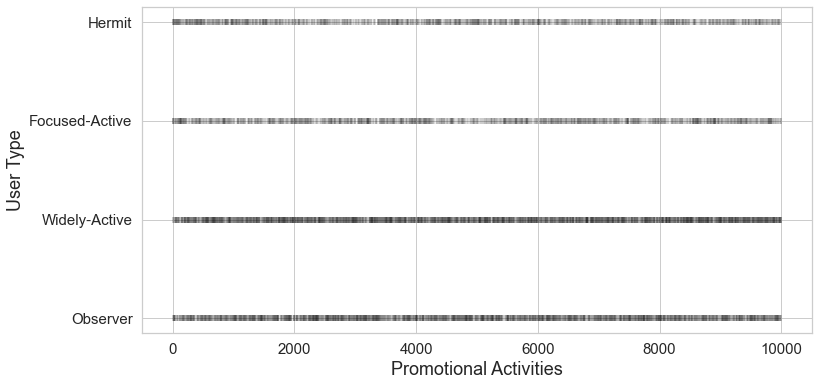

In [168]:
# Create a dictionary to map class labels to colors
df_arm_history.reset_index(inplace = True)
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style("whitegrid")

df_arm_history.loc[df_arm_history.arm == 'f_a', 'arm_name'] = 'Focused-Active'
df_arm_history.loc[df_arm_history.arm == 'w_a', 'arm_name'] = 'Widely-Active'
df_arm_history.loc[df_arm_history.arm == 'Observer', 'arm_name'] = 'Observer'
df_arm_history.loc[df_arm_history.arm == 'Hermit', 'arm_name'] = 'Hermit'

sns.scatterplot(data = df_arm_history, y = 'arm_name' , x = 'index', marker="|", alpha = 0.3, color = 'black')

plt.xlabel('Promotional Activities', fontsize = 18)
plt.ylabel('User Type', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.savefig("labnote5/mab_dyn.png");

In [169]:
df_arm_history = df_arm_history.replace(np.nan,0)
df_arm_history['cumm_direct'] = df_arm_history.direct_return.cumsum(skipna=True).astype(float)
df_arm_history['cumm_indirect'] = df_arm_history.indirect_return.cumsum(skipna=True).astype(float)

In [170]:
df_arm_history
import pandas as pd
import matplotlib.pyplot as plt

def plot_mab(data, name):
    plt.style.use('seaborn-whitegrid')
    # Create a stacked area plot
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot the "direct" column as the first area
    plt.fill_between(data.index, data['cumm_direct'], label='Direct', alpha=0.7)

    # Plot the "indirect" column as the second area stacked on top of the "direct" column
    plt.fill_between(data.index, data['cumm_direct'], data['cumm_direct'] + data['cumm_indirect'], label='Indirect', alpha=0.7, color = 'orange')

    # Customize the plot (labels, title, legend, etc.)
    plt.xlabel('Follows Sent (N)', fontsize = 15)
    plt.ylabel('Follows Received', fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend(fontsize = 15, loc = 'upper left')
    #plt.yscale('log')
    plt.ylim((0, 1750))

    # Show the plot
    plt.savefig('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/notebooks/images/plot_{}.jpg'.format(name), bbox_inches='tight')

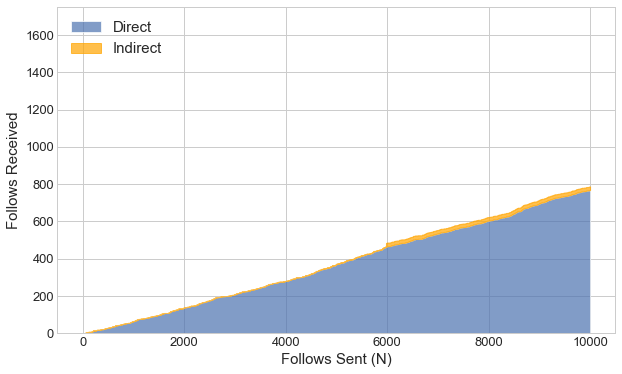

In [171]:
plot_mab(df_arm_history, 'MAB')

# Sanity Checks

In [172]:
#plot learning

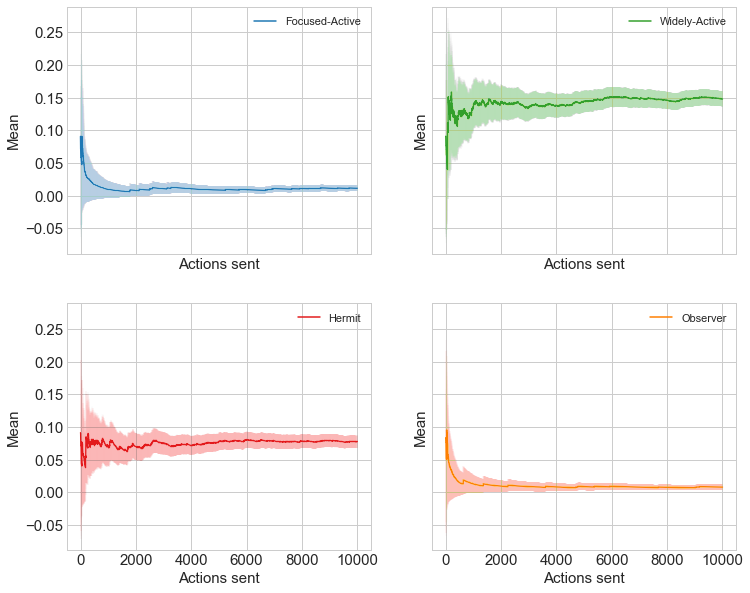

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have already loaded the data into the 'df_f_a', 'df_f_b', 'df_f_c', and 'df_f_d' DataFrames
dfs = [df_f_a, df_w_a, df_hermit, df_observer]
names = ['Focused-Active', 'Widely-Active', 'Hermit', 'Observer']

# Set the confidence level (95% in this case)
confidence_level = 0.95

# Set up the figure with multiple subplots
# Set up the figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axs array so that we can loop through the subplots in 1D
axs = axs.ravel()

# Loop through each dataframe and create individual subplots
for idx, (ax, df_) in enumerate(zip(axs, dfs)):
    mean_values = df_['mean_1']
    var_values = df_['var_1']

    # Calculate the standard error
    standard_error = var_values**(1/2)

    # Calculate the critical value for the normal distribution
    z_critical = norm.ppf((1 + confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_critical * standard_error

    # Plot the mean values and confidence intervals for each dataframe
    color = plt.cm.Paired(2*idx+1)  # Use a different color for each dataframe
    color2 = plt.cm.Paired(2*idx)
    
    ax.plot(mean_values, label='{}'.format(names[idx]), color=color)
    ax.errorbar(mean_values.index, mean_values, yerr=margin_of_error,
                color=color2, alpha=0.003)
    ax.set_ylabel('Mean', fontsize = 15)
    ax.set_xlabel('Actions sent', fontsize = 15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.legend()

# Show the plot
plt.savefig("labnote5/learning_1.png")

In [181]:
df_observer

,mean_1,mean_2,var_1,var_2,n_count,n_count_2nd
0,0.083333,1000.0,0.005876,1.0,1.0,0.0
1,0.083333,1000.0,0.005876,1.0,1.0,0.0
2,0.083333,1000.0,0.005876,1.0,1.0,0.0
3,0.083333,1000.0,0.005876,1.0,1.0,0.0
4,0.076923,1000.0,0.005072,1.0,2.0,0.0
...,...,...,...,...,...,...
9995,0.007799,0.0,0.000004,53476.171123,1784.0,13.0
9996,0.007799,0.0,0.000004,53476.171123,1784.0,13.0
9997,0.007799,0.0,0.000004,53476.171123,1784.0,13.0
9998,0.007799,0.0,0.000004,53476.171123,1784.0,13.0


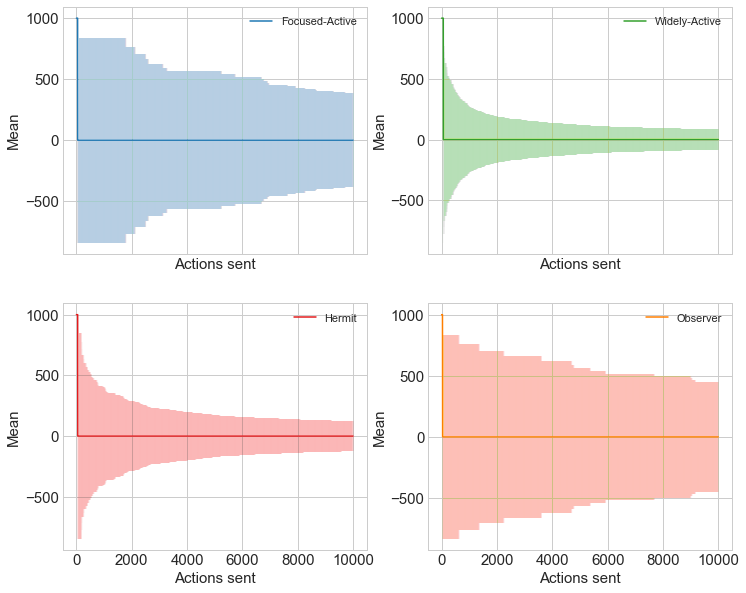

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have already loaded the data into the 'df_f_a', 'df_f_b', 'df_f_c', and 'df_f_d' DataFrames
dfs = [df_f_a, df_w_a, df_hermit, df_observer]
names = ['Focused-Active', 'Widely-Active', 'Hermit', 'Observer']

# Set the confidence level (95% in this case)
confidence_level = 0.95

# Set up the figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

# Flatten the axs array so that we can loop through the subplots in 1D
axs = axs.ravel()

# Loop through each dataframe and create individual subplots
for idx, (ax, df_) in enumerate(zip(axs, dfs)):
    mean_values = df_['mean_2']
    var_values = df_['var_2']

    # Calculate the standard error
    standard_error = var_values**(1/2)

    # Calculate the critical value for the normal distribution
    z_critical = norm.ppf((1 + confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_critical * standard_error

    # Plot the mean values and confidence intervals for each dataframe
    color = plt.cm.Paired(2*idx+1)  # Use a different color for each dataframe
    color2 = plt.cm.Paired(2*idx)
    
    ax.plot(mean_values, label='{}'.format(names[idx]), color=color)
    ax.errorbar(mean_values.index, mean_values, yerr=margin_of_error,
                color=color2, alpha=0.002)

    # Customize the plot
    ax.set_ylabel('Mean', fontsize = 15)
    ax.set_xlabel('Actions sent', fontsize = 15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.legend()
# Show the plot
plt.savefig("labnote5/learning_2.png")

In [175]:
df_observer

,mean_1,mean_2,var_1,var_2,n_count,n_count_2nd
0,0.083333,1000.0,0.005876,1.0,1.0,0.0
1,0.083333,1000.0,0.005876,1.0,1.0,0.0
2,0.083333,1000.0,0.005876,1.0,1.0,0.0
3,0.083333,1000.0,0.005876,1.0,1.0,0.0
4,0.076923,1000.0,0.005072,1.0,2.0,0.0
...,...,...,...,...,...,...
9995,0.007799,0.0,0.000004,53476.171123,1784.0,13.0
9996,0.007799,0.0,0.000004,53476.171123,1784.0,13.0
9997,0.007799,0.0,0.000004,53476.171123,1784.0,13.0
9998,0.007799,0.0,0.000004,53476.171123,1784.0,13.0


In [176]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# # Assuming you have already loaded the data into the 'df_f_a', 'df_f_b', 'df_f_c', and 'df_f_d' DataFrames
# dfs = [df_f_a, df_w_a, df_hermit, df_observer]
# names = ['Focused-Active', 'Widely-Active', 'Hermit', 'Observer']

# # Set the confidence level (95% in this case)
# confidence_level = 0.95

# # Set up the figure with multiple subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

# # Flatten the axs array so that we can loop through the subplots in 1D
# axs = axs.ravel()

# # Loop through each dataframe and create individual subplots
# for idx, (ax, df_) in enumerate(zip(axs, dfs)):
#     mean_values = df_['mean_comb']
#     var_values = df_['var_comb']

#     # Calculate the standard error
#     standard_error = var_values**(1/2)

#     # Calculate the critical value for the normal distribution
#     z_critical = norm.ppf((1 + confidence_level) / 2)

#     # Calculate the margin of error
#     margin_of_error = z_critical * standard_error

#     # Plot the mean values and confidence intervals for each dataframe
#     color = plt.cm.Paired(2*idx+1)  # Use a different color for each dataframe
#     color2 = plt.cm.Paired(2*idx)
    
#     ax.plot(mean_values, label='{}'.format(names[idx]), color=color)
#     ax.errorbar(mean_values.index, mean_values, yerr=margin_of_error,
#                 color=color2, alpha=0.002)

#     # Customize the plot
#     ax.set_ylabel('Mean')
#     ax.set_xlabel('Actions sent')
#     ax.legend()

# #ax.set_title('Proportion of followers from the target within a week of the follow-back')
# # Show the plot
# plt.show()
# #plt.savefig("labnote5/learning_3.png")

In [177]:
df_f_a

,mean_1,mean_2,var_1,var_2,n_count,n_count_2nd
0,0.090909,1000.0,0.006887,1.0,0.0,0.0
1,0.083333,1000.0,0.005876,1.0,1.0,0.0
2,0.076923,1000.0,0.005072,1.0,2.0,0.0
3,0.076923,1000.0,0.005072,1.0,2.0,0.0
4,0.076923,1000.0,0.005072,1.0,2.0,0.0
...,...,...,...,...,...,...
9995,0.011419,0.0,0.000006,38194.611111,1828.0,20.0
9996,0.011413,0.0,0.000006,38194.611111,1829.0,20.0
9997,0.011413,0.0,0.000006,38194.611111,1829.0,20.0
9998,0.011413,0.0,0.000006,38194.611111,1829.0,20.0


In [178]:
df_w_a

,mean_1,mean_2,var_1,var_2,n_count,n_count_2nd
0,0.090909,1000.0,0.006887,1.0,0.0,0.0
1,0.090909,1000.0,0.006887,1.0,0.0,0.0
2,0.090909,1000.0,0.006887,1.0,0.0,0.0
3,0.083333,1000.0,0.005876,1.0,1.0,0.0
4,0.083333,1000.0,0.005876,1.0,1.0,0.0
...,...,...,...,...,...,...
9995,0.1479,0.037549,0.000037,1838.813919,3417.0,506.0
9996,0.1479,0.037549,0.000037,1838.813919,3417.0,506.0
9997,0.147857,0.037549,0.000037,1838.813919,3418.0,506.0
9998,0.147857,0.037549,0.000037,1838.813919,3418.0,506.0


In [163]:
df_observer

,mean_1,mean_2,var_1,var_2,n_count,n_count_2nd
0,0.090909,2.0,0.006887,1.0,0.0,0.0
1,0.083333,2.0,0.005876,1.0,1.0,0.0
2,0.076923,2.0,0.005072,1.0,2.0,0.0
3,0.076923,2.0,0.005072,1.0,2.0,0.0
4,0.076923,2.0,0.005072,1.0,2.0,0.0
...,...,...,...,...,...,...
9995,0.020921,0.0,0.000085,0.983871,228.0,4.0
9996,0.020921,0.0,0.000085,0.983871,228.0,4.0
9997,0.020921,0.0,0.000085,0.983871,228.0,4.0
9998,0.020921,0.0,0.000085,0.983871,228.0,4.0


In [164]:
df_hermit

,mean_1,mean_2,var_1,var_2,n_count,n_count_2nd
0,0.166667,0.0,0.010684,1.2,1.0,1.0
1,0.166667,0.0,0.010684,1.2,1.0,1.0
2,0.166667,0.0,0.010684,1.2,1.0,1.0
3,0.166667,0.0,0.010684,1.2,1.0,1.0
4,0.153846,0.0,0.009298,1.2,2.0,1.0
...,...,...,...,...,...,...
9995,0.080577,0.0,0.000063,0.061224,1168.0,94.0
9996,0.080508,0.0,0.000063,0.061224,1169.0,94.0
9997,0.080508,0.0,0.000063,0.061224,1169.0,94.0
9998,0.080508,0.0,0.000063,0.061224,1169.0,94.0


In [165]:
mask = df['1st_reward'] == 1
max(df.loc[mask, '2nd_degree_failures'])

nan

# Pure Strategies

In [ ]:
df.loc[(df.user_type ==  'f_a')]['2nd_degree_successes'].value_counts()

In [ ]:
def pure_strat(user_type, var, num_iterations, n_sims):
    
    data = df.loc[(df[var] == user_type)
                  #&(df['1st_reward']==1)
                 ]
    


    dataframe = pd.DataFrame(index=range(num_iterations))

    # Create additional columns 'direct_i' and 'indirect_i' for i in range(1, N+1)
    for j in tqdm(range(n_sims)):
        dataframe[f'direct_{j}'] = None  # Initialize the column with None values
        dataframe[f'indirect_{j}'] = None
        
        direct = 0
        indirect = 0
        
        for i in range(num_iterations):
            row = data.sample(1, replace = True)

            direct += row['1st_reward'].values[0]
            dataframe.iloc[i,j*2] = direct

            if row['2nd_degree_successes'].values[0]>=0:
                indirect += row['2nd_degree_successes'].values[0]
            dataframe.iloc[i,(j*2)+1] = indirect

        dataframe[f'direct_{j}'] = dataframe[f'direct_{j}'].astype('float')
        dataframe[f'indirect_{j}'] = dataframe[f'indirect_{j}'].astype('float')
        
        dataframe['avg_dir'] = dataframe[[a for a in dataframe.columns if a.startswith('dir')]].mean(axis=1)
        dataframe['avg_indir'] = dataframe[[a for a in dataframe.columns if a.startswith('indir')]].mean(axis=1)

    
    return dataframe[['avg_dir', 'avg_indir']]

In [ ]:
n_iterations = 10000
n_sims = 50
var = 'user_type'
data_fa = pure_strat('f_a', var, n_iterations, n_sims)
data_fa.iloc[-1]

In [ ]:
data_wa = pure_strat('w_a', var, n_iterations, n_sims)
data_wa.iloc[-1]

In [ ]:
data_hermit = pure_strat('Hermit', var, n_iterations, n_sims)
data_hermit.iloc[-1]

In [ ]:
data_observer = pure_strat('Observer', var, n_iterations, n_sims)
data_observer.iloc[-1]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sim(data, name):
    plt.style.use('seaborn-whitegrid')
    # Create a stacked area plot
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot the "direct" column as the first area
    plt.fill_between(data.index, data['avg_dir'], label='Direct', alpha=0.7)

    # Plot the "indirect" column as the second area stacked on top of the "direct" column
    plt.fill_between(data.index, data['avg_dir'], data['avg_dir'] + data['avg_indir'], label='Indirect', alpha=0.7)

    # Customize the plot (labels, title, legend, etc.)
    plt.xlabel('Follows Sent (N)', fontsize = 15)
    plt.ylabel('Follows Received', fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend(fontsize = 15, loc = 'upper left')
    #plt.yscale('log')
    plt.ylim((0, 1750))

    # Show the plot
    plt.savefig('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/notebooks/images/plot_{}.jpg'.format(name), bbox_inches='tight')

In [ ]:
plot_sim(data_fa, 'data_fa')

In [ ]:
plot_sim(data_wa, 'data_wa')

In [ ]:
plot_sim(data_hermit, 'data_hermit')

In [ ]:
plot_sim(data_observer, 'data_observer')

In [ ]:
df

In [ ]:
table_data.groupby('Type').followers.describe()

In [ ]:
(table_data.loc[table_data.Type == 'f_a'].followers > 5).sum()

In [ ]:
table_data.loc[table_data.Type == 'f_a']

In [ ]:
df

# At least 5 alters

In [ ]:
table_data = pd.read_csv('user_types_ids.csv')

hermit_ids = table_data.loc[table_data.Type =='Hermit'].user_id.unique()
w_a_ids = table_data.loc[table_data.Type =='w_a'].user_id.unique()
f_a_ids = table_data.loc[table_data.Type =='f_a'].user_id.unique()
f_a_4_ids = table_data.loc[(table_data.Type =='f_a')&(table_data.followers>4)].user_id.unique()
observer_ids = table_data.loc[table_data.Type =='Observer'].user_id.unique()

In [ ]:
len(f_a_4_ids)

In [ ]:
df['user_type2'] = df.fan_id.apply(lambda x: 'f_a_4' if x in f_a_4_ids else 
                          ('Hermit' if x in hermit_ids else
                          ('Observer' if x in observer_ids else
                          ('w_a' if x in w_a_ids else 'other'))))

In [ ]:
var = 'user_type2'
data_fa_4 = pure_strat('f_a_4', var, n_iterations, n_sims)
data_fa_4.iloc[-1]

In [ ]:
plot_sim(data_fa_4, 'data_fa')

In [ ]:
df.loc[df['user_type'] == 'f_a_5'].n_shares.describe()

In [ ]:
bandit.pull_arm()

In [ ]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "poisson"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [242]:
follows_sent_non_fans.loc[follows_sent_non_fans.user_type == 'f_a', 'user_type'] = 'Focused-Actives'
follows_sent_non_fans.loc[follows_sent_non_fans.user_type == 'w_a', 'user_type'] = 'Widely-Actives'
follows_sent_non_fans.loc[follows_sent_non_fans.user_type == 'Observer', 'user_type'] = 'Observers'
follows_sent_non_fans.loc[follows_sent_non_fans.user_type == 'Hermit', 'user_type'] = 'Hermits'

In [243]:
mask = (follows_sent_non_fans.creator_type == 'successful') & (follows_sent_non_fans.user_type
                                                               .isin(['Focused-Actives', 'Widely-Actives', 'Observers', 'Hermits']))

follows_sent_non_fans[mask]

,user_id,fan_id,date_sent,outbound_activity,follower_since,week_yr_date,1st_reward,user_type,creator_type,follower_since_day
1850,38049253,13657244,2013-03-03 04:43:49,follow,NaT,2013-03-03,0,Widely-Actives,successful,NaT
1879,38049253,16400846,2013-03-03 05:56:04,follow,NaT,2013-03-03,0,Hermits,successful,NaT
1881,38049253,20146084,2013-03-03 05:56:10,follow,NaT,2013-03-03,0,Hermits,successful,NaT
1883,38049253,10100086,2013-03-03 05:57:41,follow,NaT,2013-03-03,0,Hermits,successful,NaT
1884,38049253,28987567,2013-03-03 05:58:18,follow,NaT,2013-03-03,0,Widely-Actives,successful,NaT
...,...,...,...,...,...,...,...,...,...,...
800516,38354639,69861750,2015-04-23 22:03:14,follow,NaT,2015-04-23,0,Focused-Actives,successful,NaT
800578,37884556,30597862,2015-06-08 05:21:16,follow,NaT,2015-06-08,0,Focused-Actives,successful,NaT
800736,38491073,153282021,2015-05-17 00:12:09,follow,NaT,2015-05-17,0,Hermits,successful,NaT
800819,38404408,4285409,2015-06-04 22:22:54,follow,NaT,2015-06-04,0,Widely-Actives,successful,NaT


In [266]:
def plot_learning(data, filename):
    
    sns.set(font_scale=1.3)
    
    data = data[['user_type', 'creator_type', 'week_yr_date']]
    data_grouped = data.groupby('week_yr_date', as_index = False).size()
    data.columns = ['user_type', 'creator_type', 'week_yr_date']
    
    lim_inf = min(data.week_yr_date)
    lim_sup = max(data.week_yr_date)
    
    fig, ax = plt.subplots(figsize=(15, 9))

    hue_order_l = ['Focused-Actives', 'Widely-Actives', 'Observers', 'Hermits']

    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")
    sns.kdeplot(data=data,
            x="week_yr_date",
            hue='user_type',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
    .set(xlim=(lim_inf, lim_sup), xlabel='Week', ylabel='Share')
    
    plt.savefig('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/notebooks/images/plot_{}.jpg'.format(filename), bbox_inches='tight')
    
#     ax2 = plt.twinx()
#     sns.lineplot(data=data_grouped,
#                  x = "week_yr_date", 
#                  y = "size", 
#                  color="black", 
#                  ax=ax2, 
#                  legend = 'auto',
#                  linewidth = 1)\
#     .set(ylabel='Total Promotional Actions', yscale="log")
#     plt.annotate('''Note: each color corresponds to a receiver type. The black line is the total number of actions per week.'''
#              , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);



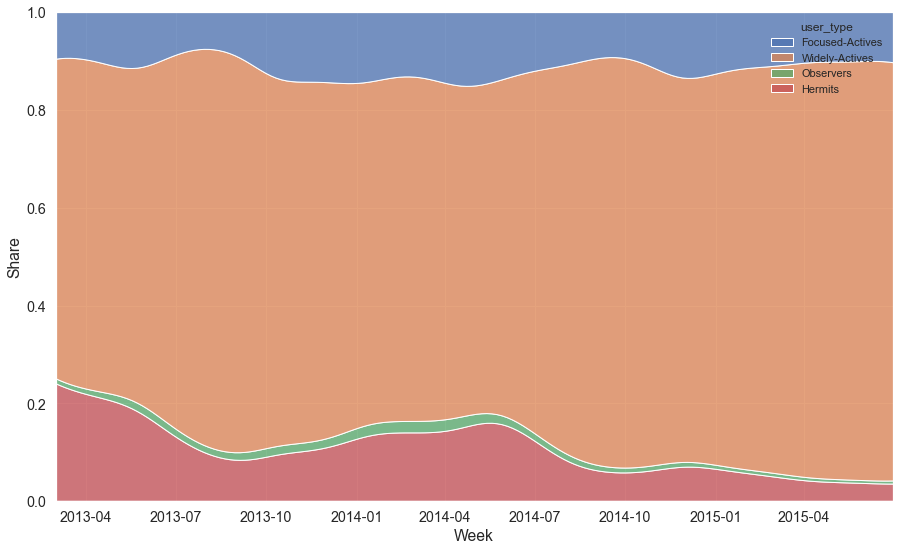

In [267]:
mask = (follows_sent_non_fans.creator_type == 'successful') & (follows_sent_non_fans.user_type
                                                               .isin(['Focused-Actives', 'Widely-Actives', 'Observers', 'Hermits']))

follows_sent_non_fans[mask]
plot_learning(follows_sent_non_fans[mask], 'successful_behavior')

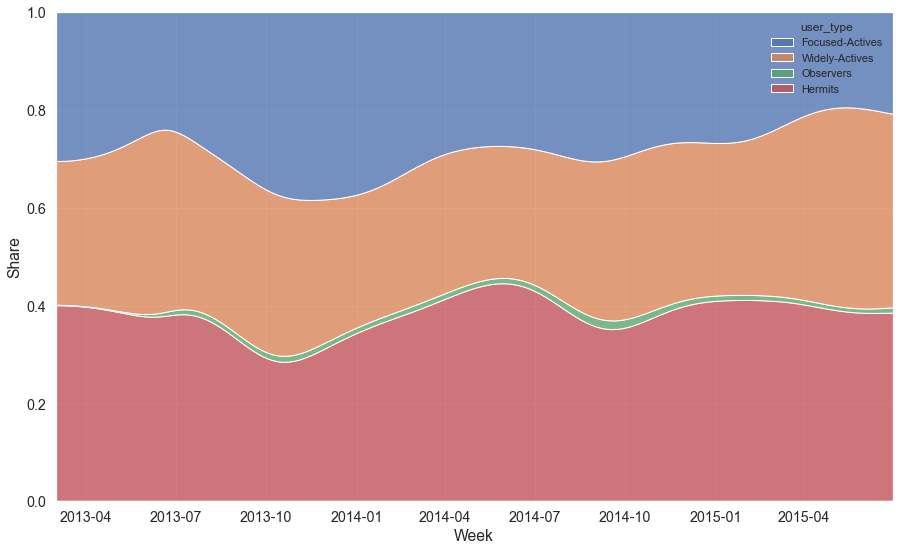

In [268]:
mask = (follows_sent_non_fans.creator_type == 'unsuccessful') & (follows_sent_non_fans.user_type
                                                               .isin(['Focused-Actives', 'Widely-Actives', 'Observers', 'Hermits']))

follows_sent_non_fans[mask]
plot_learning(follows_sent_non_fans[mask], 'unsuccessful_behavior')